# Early Oct. voter registration update

In this notebook, we'll look at overall registration totals and the voter share each major party has.

We'll compare to historical data in the enrollment-pdf directory to see where we stand compared to previous cycles.

Here are some questions we'll want to answer:

* How does the current number of voters compare with past cycles?
* How does the party mix compare with past cycles?
* If turnout resembles past cycles, how many voters from each party would cast ballots next month?

# Importing and combining data

Before we can even think about answering these questions, we need to combine data.

I've downloaded historical registration data going back to 1958 and converted it all to spreadsheets. Now let's have some fun.

In [1]:
import pandas as pd
import re

In [2]:
def clean_colname(col_name):
    
    ret = col_name
    
    ret = re.sub("[^A-Z0-9 ]+"," ",col_name.upper().replace("%","PCT")).strip()
    
    ret = re.sub(" +"," ",ret)
    
    return ret

clean_colname("Unaffiliated\n% of Total Registered\n***")

'UNAFFILIATED PCT OF TOTAL REGISTERED'

In [3]:
def get_historical():
    
    ret = pd.read_excel("enrollment-pdf/excel-exports/enrolhstpdf.xlsx")
    
    # Drop repeated column headers
    ret = ret[ret["Democratic"] != "Democratic"]
    
    # Drop nulls
    ret = ret.dropna(thresh=10)
   
    ret["year"] = ret["Reporting Date/Year"].apply(lambda x: int(x[-4:]))
    
    ret.columns = map(clean_colname,ret.columns.tolist())

    return ret

historical = get_historical()
historical.tail()

,REPORTING DATE YEAR,DEMOCRATIC,D PCT OF TOTAL REGISTERED,REPUBLICAN,R PCT OF TOTAL REGISTERED,OTHER PARTIES,OTHER PARTIES PCT OF TOTAL REGISTERED,ALL PARTIES COMBINED,ALL PARTIES COMBINED PCT OF TOTAL REGISTERED,UNAFFILIATED,UNAFFILIATED PCT OF TOTAL REGISTERED,TOTAL REGISTERED,REPORTING DATE YEAR 1,YEAR
43,"*Oct. 24, 2000",643822,0.344,452654,0.242,4164,0.002,1100640,0.587,773605,0.413,1874245,"Oct. 24, 2000*",2000
44,"*Oct. 23, 2001",636404,0.343,440786,0.237,4461,0.002,1081651,0.583,775085,0.417,1856736,"Oct. 23, 2001*",2001
45,"*Oct. 22, 2002",629422,0.342,431443,0.234,4894,0.003,1065759,0.578,776706,0.422,1842465,"Oct. 22, 2002*",2002
46,"*Oct. 21, 2003",623453,0.342,422027,0.231,4161,0.002,1049641,0.576,773809,0.424,1823450,"Oct. 21, 2003*",2003
47,"*Oct. 19, 2004",670356,0.337,438554,0.22,4465,0.002,1113375,0.56,876538,0.44,1989913,"*Oct. 19, 2004",2004


In [4]:
%matplotlib inline

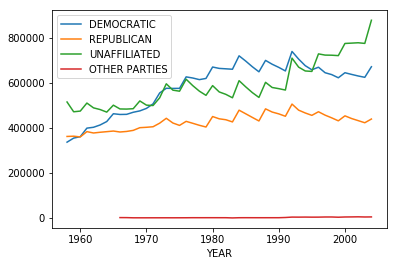

In [5]:
historical.set_index("YEAR")[["DEMOCRATIC","REPUBLICAN","UNAFFILIATED","OTHER PARTIES"]].plot()

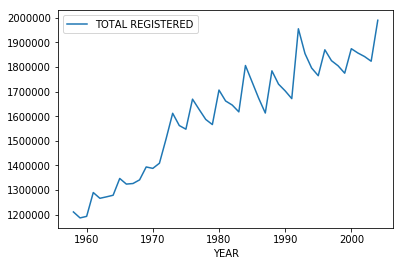

In [6]:
historical.set_index("YEAR")[["TOTAL REGISTERED"]].plot()

In [7]:
def clean_historical(df):
    
    ret = df.copy()

    ret = ret[["YEAR","REPUBLICAN","DEMOCRATIC","OTHER PARTIES","UNAFFILIATED","TOTAL REGISTERED"]]
    ret = ret.set_index("YEAR")

    parties = ["REPUBLICAN","DEMOCRATIC","OTHER PARTIES","UNAFFILIATED","TOTAL REGISTERED"]
    
    tuples = map(lambda x: (x, "ACTIVE"),parties)
    
    ret.columns = pd.MultiIndex.from_tuples(tuples)
    
    return ret

clean_historical(historical).head()

,REPUBLICAN,DEMOCRATIC,OTHER PARTIES,UNAFFILIATED,TOTAL REGISTERED
,ACTIVE,ACTIVE,ACTIVE,ACTIVE,ACTIVE
YEAR,,,,,
1958,361257,335887,NaN,514060,1211204
1959,362395,353907,NaN,470645,1186947
1960,359162,360363,NaN,473727,1193252
1961,382621,398136,NaN,509332,1290089
1962,376617,401932,NaN,488064,1266613


In [8]:
def full_index():
    parties = [
        "REPUBLICAN","REPUBLICAN","REPUBLICAN",
        "DEMOCRATIC","DEMOCRATIC","DEMOCRATIC",
        "OTHER PARTIES","OTHER PARTIES","OTHER PARTIES",
        "UNAFFILIATED","UNAFFILIATED","UNAFFILIATED",
        "TOTAL REGISTERED","TOTAL REGISTERED","TOTAL REGISTERED"]
    
    sub_cols = ["ACTIVE","INACTIVE","TOTAL"]*5
    
    tuples = list(zip(parties, sub_cols))
    
    index = pd.MultiIndex.from_tuples(tuples)#, names=['PARTY', 'COUNT_TYPE'])
    
    return index


In [9]:
def get_2005_type(fname="enrollment-pdf/excel-exports/2005OctRegEnrollStatspdf.xlsx",
                  year=2005,
                 skiprows=194,
                 skipfooter=32,
                 ):
    
    
    ret = pd.read_excel(fname,
                       skiprows=skiprows,
                       skipfooter=skipfooter,
                       header=None).dropna(how="any",axis=1)
    
    #ret.columns = ["DISTRICT"] + ret.columns.tolist()[1:]
    
    ret = ret.dropna(axis=1,how="all").set_index(0)#"DISTRICT")
    
    ret.columns = full_index()

    #ret.columns = map(clean_colname,ret.columns.tolist())
    
    ret = ret.loc["Total"].to_frame().transpose()
    
    ret["YEAR"] = year
    
    return ret.set_index("YEAR")

get_2005_type()


REPUBLICAN                  DEMOCRATIC                  OTHER PARTIES  \
         ACTIVE INACTIVE   TOTAL     ACTIVE INACTIVE   TOTAL        ACTIVE   
YEAR                                                                         
2005     427803    25912  453715     653055    46447  699502          4029   

                    UNAFFILIATED                  TOTAL REGISTERED           \
     INACTIVE TOTAL       ACTIVE INACTIVE   TOTAL           ACTIVE INACTIVE   
YEAR                                                                          
2005      358  4387       867761    61244  929005          1952648   133961   

               
        TOTAL  
YEAR           
2005  2086609

In [10]:
def get_2006_type(cell=(8,0),
                  fname="enrollment-pdf/excel-exports/2006RegEnrollStatspdf.xlsx",
                  year=2006,
                  skiprows=194,
                  skipfooter=32,
                  skip_index=0,
                 ):
    
    """ For this type of spreadsheet, there is no CONG subsheet, and
        the totals are all in one cell """
        
    ret = pd.read_excel(fname,
                       skiprows=skiprows,
                       skipfooter=skipfooter,
                       header=None).dropna(how="any",axis=1)
    
    #return ret
    ret = ret.loc[cell[0]][cell[1]]
    
    
    ret = pd.DataFrame(map(lambda x: x.replace(",",""),str(ret).split()[skip_index:])).transpose()
    
    ret = ret.set_index(0)
    
    ret.columns = full_index()
    
    ret["YEAR"] = year
    
    ret = ret.set_index("YEAR")
    
    return ret

get_2006_type()


REPUBLICAN                  DEMOCRATIC                  OTHER PARTIES  \
         ACTIVE INACTIVE   TOTAL     ACTIVE INACTIVE   TOTAL        ACTIVE   
YEAR                                                                         
2006     411800    21229  433029     663517    41294  704811          2615   

                    UNAFFILIATED                  TOTAL REGISTERED           \
     INACTIVE TOTAL       ACTIVE INACTIVE   TOTAL           ACTIVE INACTIVE   
YEAR                                                                          
2006      266  2881       844438    61328  905766          1922370   124117   

               
        TOTAL  
YEAR           
2006  2046487

In [11]:
def combine_dfs(*df_arr):
        
    ret = pd.concat(*df_arr)
    
    return ret
    
combine_dfs([
    clean_historical(historical),
    get_2005_type(),
    get_2006_type(),
]).tail()

DEMOCRATIC                  OTHER PARTIES                REPUBLICAN  \
         ACTIVE INACTIVE   TOTAL        ACTIVE INACTIVE TOTAL     ACTIVE   
YEAR                                                                       
2002     629422      NaN     NaN          4894      NaN   NaN     431443   
2003     623453      NaN     NaN          4161      NaN   NaN     422027   
2004     670356      NaN     NaN          4465      NaN   NaN     438554   
2005     653055    46447  699502          4029      358  4387     427803   
2006     663517    41294  704811          2615      266  2881     411800   

                      TOTAL REGISTERED                   UNAFFILIATED  \
     INACTIVE   TOTAL           ACTIVE INACTIVE    TOTAL       ACTIVE   
YEAR                                                                    
2002      NaN     NaN          1842465      NaN      NaN       776706   
2003      NaN     NaN          1823450      NaN      NaN       773809   
2004      NaN     NaN          1989913      NaN      NaN       876538   
2005    25912  453715          1952648   133961  2086609       867761   
2006    21229  433029          1922370   124117  2046487       844438   

                       
     INACTIVE   TOTAL  
YEAR                   
2002      NaN     NaN  
2003      NaN     NaN  
2004      NaN     NaN  
2005    61244  929005  
2006    61328  905766

In [12]:
def get_2007_type(fname="enrollment-pdf/excel-exports/2007RegistrationandEnrollmentStatisticspdf.xlsx",
                 town_col="Town Summary",
                  skiprows=0,
                  total_str="Total",
                  year=2007):
    
    ret = pd.read_excel(fname,skiprows=skiprows)
    
    ret = ret.set_index(town_col)
    
    #ret = ret[ret.index == total_str]
    ret = ret.loc[total_str]
    ret = ret.to_frame()
    ret = ret.transpose()
    ret = ret.dropna(how="all",axis=1)
    ret.columns = full_index()
    ret["YEAR"] = year
    ret = ret.set_index("YEAR")
    return ret

get_2007_type()

REPUBLICAN                  DEMOCRATIC                  OTHER PARTIES  \
         ACTIVE INACTIVE   TOTAL     ACTIVE INACTIVE   TOTAL        ACTIVE   
YEAR                                                                         
2007     406203    20935  427138     665223    42208  707431          7249   

                    UNAFFILIATED                  TOTAL REGISTERED           \
     INACTIVE TOTAL       ACTIVE INACTIVE   TOTAL           ACTIVE INACTIVE   
YEAR                                                                          
2007      469  7718       839049    63175  902224          1917724   126787   

               
        TOTAL  
YEAR           
2007  2044511

In [13]:
combine_dfs([
    clean_historical(historical),
    get_2005_type(),
    get_2006_type(),
    get_2007_type(),
]).tail()

DEMOCRATIC                  OTHER PARTIES                REPUBLICAN  \
         ACTIVE INACTIVE   TOTAL        ACTIVE INACTIVE TOTAL     ACTIVE   
YEAR                                                                       
2003     623453      NaN     NaN          4161      NaN   NaN     422027   
2004     670356      NaN     NaN          4465      NaN   NaN     438554   
2005     653055    46447  699502          4029      358  4387     427803   
2006     663517    41294  704811          2615      266  2881     411800   
2007     665223    42208  707431          7249      469  7718     406203   

                      TOTAL REGISTERED                   UNAFFILIATED  \
     INACTIVE   TOTAL           ACTIVE INACTIVE    TOTAL       ACTIVE   
YEAR                                                                    
2003      NaN     NaN          1823450      NaN      NaN       773809   
2004      NaN     NaN          1989913      NaN      NaN       876538   
2005    25912  453715          1952648   133961  2086609       867761   
2006    21229  433029          1922370   124117  2046487       844438   
2007    20935  427138          1917724   126787  2044511       839049   

                       
     INACTIVE   TOTAL  
YEAR                   
2003      NaN     NaN  
2004      NaN     NaN  
2005    61244  929005  
2006    61328  905766  
2007    63175  902224

In [14]:
get_2007_type(
    year=2008,
    fname="enrollment-pdf/excel-exports/2008RegistrationandEnrollmentStatisticspdf.xlsx",
    skiprows=1,
    town_col="Andover",
    total_str="Totals")

REPUBLICAN                  DEMOCRATIC                  OTHER PARTIES  \
         ACTIVE INACTIVE   TOTAL     ACTIVE INACTIVE   TOTAL        ACTIVE   
YEAR                                                                         
2008     427110    18548  445658     780338    37097  817435          7550   

                    UNAFFILIATED                  TOTAL REGISTERED           \
     INACTIVE TOTAL       ACTIVE INACTIVE   TOTAL           ACTIVE INACTIVE   
YEAR                                                                          
2008      509  8059       884023    55259  939282          2099021   111413   

                   
            TOTAL  
YEAR               
2008  2.21043e+06

In [15]:
get_2007_type(
    year=2013,
    fname="enrollment-pdf/excel-exports/Nov13REpdf.xlsx",
    skiprows=0,
    town_col="Town",
    total_str="Totals"
)


REPUBLICAN                  DEMOCRATIC                  OTHER PARTIES  \
         ACTIVE INACTIVE   TOTAL     ACTIVE INACTIVE   TOTAL        ACTIVE   
YEAR                                                                         
2013     414747    21803  436550     741404    57074  798478         18671   

                     UNAFFILIATED                  TOTAL REGISTERED           \
     INACTIVE  TOTAL       ACTIVE INACTIVE   TOTAL           ACTIVE INACTIVE   
YEAR                                                                           
2013     1169  19840       842751    74784  917535          2017570   154830   

                  
           TOTAL  
YEAR              
2013  2.1724e+06

In [16]:
def get_2012_type(fname="enrollment-pdf/excel-exports/Nov12REpdf.xlsx",
                 town_col="Town Summary",
                  skiprows=176,
                  skipfooter=21,
                  total_str="Totals",
                  year=2012):
    
    ret = pd.read_excel(fname,skiprows=skiprows,skipfooter=skipfooter)
    
    ret = ret.loc[0].combine_first(ret.loc[1])
    
    #ret = ret[ret.index == total_str]
    #ret = ret.loc[total_str]
    ret = ret.to_frame()#.set_index()
    ret = ret.transpose()
#     ret = ret.set_index(town_col)

#     ret = ret.transpose()
    ret = ret.dropna(how="all",axis=1)
        
    ret["YEAR"] = year
    
    ret = ret[ret.columns.tolist()[1:]]
    ret = ret.set_index("YEAR")
    
    ret.columns = full_index()

    return ret

get_2012_type()

REPUBLICAN                  DEMOCRATIC                  OTHER PARTIES  \
         ACTIVE INACTIVE   TOTAL     ACTIVE INACTIVE   TOTAL        ACTIVE   
YEAR                                                                         
2012     430564    19084  449648     768176    47537  815713         18960   

                     UNAFFILIATED                  TOTAL REGISTERED           \
     INACTIVE  TOTAL       ACTIVE INACTIVE   TOTAL           ACTIVE INACTIVE   
YEAR                                                                           
2012     1063  20023       872839    60440  933279      2.09054e+06   128123   

                   
            TOTAL  
YEAR               
2012  2.21866e+06

In [17]:
get_2007_type(
        year=2017,
        fname="enrollment-pdf/excel-exports/Copy-of-Nov18RE.xlsx",
        skiprows=0,
        town_col="Town",
        total_str="Totals"
    ),

(     REPUBLICAN                  DEMOCRATIC                  OTHER PARTIES  \
          ACTIVE INACTIVE   TOTAL     ACTIVE INACTIVE   TOTAL        ACTIVE   
 YEAR                                                                         
 2017     463168    25902  489070     792555    70870  863425         32113   
 
                      UNAFFILIATED                  TOTAL REGISTERED           \
      INACTIVE  TOTAL       ACTIVE INACTIVE   TOTAL           ACTIVE INACTIVE   
 YEAR                                                                           
 2017     2498  34611       877392    25902  903294          2165228    85085   
 
                
         TOTAL  
 YEAR           
 2017  2250313  ,)

In [18]:
combined = combine_dfs([
    clean_historical(historical),
    get_2005_type(),
    get_2006_type(),
    get_2007_type(),
    get_2007_type(
        year=2008,
        fname="enrollment-pdf/excel-exports/2008RegistrationandEnrollmentStatisticspdf.xlsx",
        skiprows=1,
        town_col="Andover",
        total_str="Totals"
    ),
    get_2007_type(
        year=2009,
        fname="enrollment-pdf/excel-exports/2009RegistrationandEnrollmentStatisticspdf.xlsx",
        skiprows=1,
        town_col="Andover",
        total_str="Totals"
    ),
    get_2007_type(
        year=2010,
        fname="enrollment-pdf/excel-exports/2010RegistrationandEnrollmentStatisticspdf.xlsx",
        skiprows=1,
        town_col="Andover",
        total_str="Totals"
    ),
    get_2006_type(cell=(9,0),
          fname="enrollment-pdf/excel-exports/2011RegistrationandEnrollmentStatisticspdf.xlsx",
          year=2011,
          skiprows=170,
          skipfooter=0,
          skip_index=1
    ),
    get_2012_type(),
    get_2007_type(
        year=2013,
        fname="enrollment-pdf/excel-exports/Nov13REpdf.xlsx",
        skiprows=0,
        town_col="Town",
        total_str="Totals"
    ),
    get_2007_type(
        year=2014,
        fname="enrollment-pdf/excel-exports/Nov14RE2pdf.xlsx",
        skiprows=0,
        town_col="Town",
        total_str="Totals"
    ),
    get_2007_type(
        year=2015,
        fname="enrollment-pdf/excel-exports/Nov15REpdf.xlsx",
        skiprows=0,
        town_col="Town",
        total_str="Totals"
    ),
    get_2007_type(
        year=2016,
        fname="enrollment-pdf/excel-exports/Nov16RE-pdf.xlsx",
        skiprows=0,
        town_col="Town",
        total_str="Totals"
    ),
    get_2007_type(
        year=2017,
        fname="enrollment-pdf/excel-exports/Nov17RPES.xlsx",
        skiprows=0,
        town_col="Town",
        total_str="Totals"
    ),
    get_2007_type(
            year=2017,
            fname="enrollment-pdf/excel-exports/Copy-of-Nov18RE.xlsx",
            skiprows=0,
            town_col="Town",
            total_str="Totals"
        ),
])

for c in combined.columns:
    combined[c] = pd.to_numeric(combined[c])
combined.tail(20)

DEMOCRATIC                    OTHER PARTIES                   REPUBLICAN  \
         ACTIVE INACTIVE     TOTAL        ACTIVE INACTIVE    TOTAL     ACTIVE   
YEAR                                                                            
1999   621469.0      NaN       NaN        3131.0      NaN      NaN   430528.0   
2000   643822.0      NaN       NaN        4164.0      NaN      NaN   452654.0   
2001   636404.0      NaN       NaN        4461.0      NaN      NaN   440786.0   
2002   629422.0      NaN       NaN        4894.0      NaN      NaN   431443.0   
2003   623453.0      NaN       NaN        4161.0      NaN      NaN   422027.0   
2004   670356.0      NaN       NaN        4465.0      NaN      NaN   438554.0   
2005   653055.0  46447.0  699502.0        4029.0    358.0   4387.0   427803.0   
2006   663517.0  41294.0  704811.0        2615.0    266.0   2881.0   411800.0   
2007   665223.0  42208.0  707431.0        7249.0    469.0   7718.0   406203.0   
2008   780338.0  37097.0  817435.0        7550.0    509.0   8059.0   427110.0   
2009   751612.0  41322.0  792934.0       10709.0    727.0  11436.0   412746.0   
2010   751360.0  43152.0  794512.0       12762.0    832.0  13594.0   419353.0   
2011   736082.0  48198.0  784280.0       13531.0    993.0  14524.0   411866.0   
2012   768176.0  47537.0  815713.0       18960.0   1063.0  20023.0   430564.0   
2013   741404.0  57074.0  798478.0       18671.0   1169.0  19840.0   414747.0   
2014   712925.0  72962.0  785887.0       20168.0   1638.0  21806.0   407519.0   
2015   703851.0  73035.0  776886.0       20610.0   1883.0  22493.0   400216.0   
2016   810136.0  59705.0  869841.0       28050.0   1582.0  29632.0   467687.0   
2017   771412.0  77081.0  848493.0       29668.0   2291.0  31959.0   453625.0   
2017   792555.0  70870.0  863425.0       32113.0   2498.0  34611.0   463168.0   

                        TOTAL REGISTERED                      UNAFFILIATED  \
     INACTIVE     TOTAL           ACTIVE  INACTIVE      TOTAL       ACTIVE   
YEAR                                                                         
1999      NaN       NaN        1774811.0       NaN        NaN     719683.0   
2000      NaN       NaN        1874245.0       NaN        NaN     773605.0   
2001      NaN       NaN        1856736.0       NaN        NaN     775085.0   
2002      NaN       NaN        1842465.0       NaN        NaN     776706.0   
2003      NaN       NaN        1823450.0       NaN        NaN     773809.0   
2004      NaN       NaN        1989913.0       NaN        NaN     876538.0   
2005  25912.0  453715.0        1952648.0  133961.0  2086609.0     867761.0   
2006  21229.0  433029.0        1922370.0  124117.0  2046487.0     844438.0   
2007  20935.0  427138.0        1917724.0  126787.0  2044511.0     839049.0   
2008  18548.0  445658.0        2099021.0  111413.0  2210434.0     884023.0   
2009  20311.0  433057.0        2028674.0  123646.0  2152320.0     853607.0   
2010  19120.0  438473.0        2026874.0  123759.0  2150633.0     843399.0   
2011  19855.0  431721.0        1989462.0  131980.0  2121442.0     827983.0   
2012  19084.0  449648.0        2090539.0  128123.0  2218662.0     872839.0   
2013  21803.0  436550.0        2017570.0  154830.0  2172400.0     842751.0   
2014  27189.0  434708.0        1958993.0  199365.0  2158358.0     818381.0   
2015  29085.0  429301.0        1923103.0  206276.0  2129379.0     798426.0   
2016  24537.0  492224.0        2187349.0  170384.0  2357733.0     881476.0   
2017  27711.0  481336.0        2116471.0  201780.0  2318251.0     861766.0   
2017  25902.0  489070.0        2165228.0   85085.0  2250313.0     877392.0   

                          
      INACTIVE     TOTAL  
YEAR                      
1999       NaN       NaN  
2000       NaN       NaN  
2001       NaN       NaN  
2002       NaN       NaN  
2003       NaN       NaN  
2004       NaN       NaN  
2005   61244.0  929005.0  
2006   61328.0  905766.0  
2007   63175.0  902224.0  
2008   55259.0  939282

In [19]:
# Now we have to add 2018 October numbers
def get_2018_type():
    oct18inactive = pd.read_csv("data/inactive-oct-2-2018.mess.csv")
    oct18active = pd.read_csv("data/active-oct-2-2018.mess.csv")
    
    bigs = ["REPUBLICAN","DEMOCRATIC","OTHER PARTIES","UNAFFILIATED"]
    parties = ["REPUBLICAN","DEMOCRATIC","OTHER PARTIES","UNAFFILIATED","TOTAL REGISTERED"]

    def clean_18_type(df, header=""):
        ret = df[df["PARTY"].apply(lambda x: "----" not in str(x) )]
        ret["PARTY"] = ret["PARTY"].apply(clean_colname)
        ret["COUNT"] = pd.to_numeric(ret["COUNT"])
        ret = ret.set_index("PARTY")
        #ret["YEAR"] = 2018
        #ret.columns = pd.MultiIndex.from_tuples((""))
        
        # Add an "OTHER PARTIES" column by creating a new DF and 
        # concatenating it
        other_parties = ret[ret.index.map(lambda x: x not in bigs)].sum().to_frame()
        other_parties.columns = ["COUNT"]#,"YEAR"]
        other_parties["YEAR"] = 2018
        other_parties.index = other_parties.index.map(lambda _: "OTHER PARTIES")
        big_df = ret[ret.index.map(lambda x: x in bigs)]
        
        ret = pd.concat([
            big_df, 
            other_parties
        ])
        
        return ret
    
    oct18active = clean_18_type(oct18active, header="ACTIVE")
    oct18inactive = clean_18_type(oct18inactive, header="INACTIVE")
    
    ret = oct18active["COUNT"].transpose().to_frame()#.join(oct18inactive["COUNT"],lsuffix="_ACTIVE",rsuffix="_INACTIVE")
    
    #ret["YEAR"] = 2018
    
    #ret.columns = map(lambda x: x.replace("COUNT_", ""), ret.columns.tolist())
    
    #ret = ret.reset_index()
    
    return ret

get_2018_type()

/Users/jakekara/pandas/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/jakekara/pandas/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/jakekara/pandas/lib/python2.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept t

,COUNT
DEMOCRATIC,778001
REPUBLICAN,456611
UNAFFILIATED,862466
OTHER PARTIES,31177


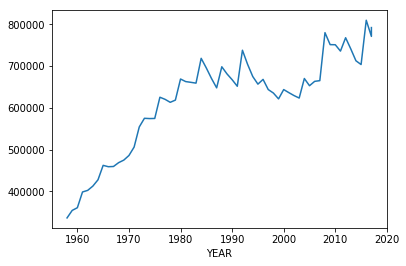

In [20]:
combined[("DEMOCRATIC","ACTIVE")].plot()

/Users/jakekara/pandas/lib/python2.7/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


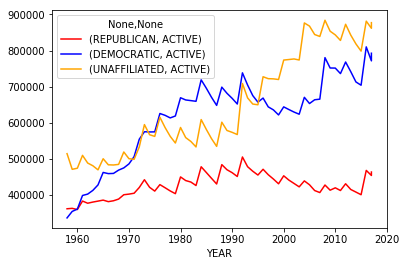

In [21]:
combined[filter(
    lambda x: x[1] == "ACTIVE" and x[0] in ["DEMOCRATIC","REPUBLICAN","UNAFFILIATED"],
    full_index()
)].plot(colors=["RED","BLUE","ORANGE"])

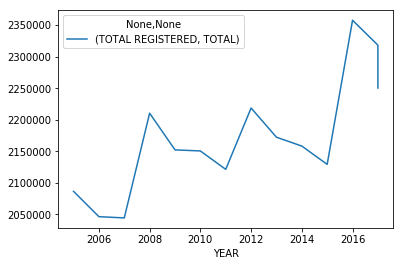

In [22]:
combined[filter(
    lambda x: x[1] == "TOTAL" and x[0] in ["TOTAL REGISTERED"],
    full_index()
)].plot()

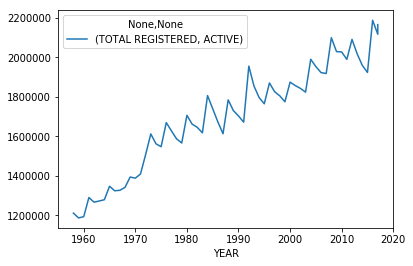

In [23]:
combined[filter(
    lambda x: x[1] == "ACTIVE" and x[0] in ["TOTAL REGISTERED"],
    full_index()
)].plot()

In [24]:
import numpy as np
def check_totals(df):
    
    ret = df.copy()
    
    for party in df.columns.get_level_values(0).unique():
        ret[party, "_COMPUTED_TOTAL"] = ret[party]["ACTIVE"].fillna(0) + ret[party]["INACTIVE"].fillna(0)
        ret[party, "_DIFF"] = ret[party, "_COMPUTED_TOTAL"] - ret[party, "TOTAL"].fillna(0)  
        ret[party, "_PCT_INACTIVE"] = ret[party,"INACTIVE"] / (ret[party,"TOTAL"])
    
    return ret

check_totals(combined)

DEMOCRATIC                    OTHER PARTIES                   REPUBLICAN  \
         ACTIVE INACTIVE     TOTAL        ACTIVE INACTIVE    TOTAL     ACTIVE   
YEAR                                                                            
1958   335887.0      NaN       NaN           NaN      NaN      NaN   361257.0   
1959   353907.0      NaN       NaN           NaN      NaN      NaN   362395.0   
1960   360363.0      NaN       NaN           NaN      NaN      NaN   359162.0   
1961   398136.0      NaN       NaN           NaN      NaN      NaN   382621.0   
1962   401932.0      NaN       NaN           NaN      NaN      NaN   376617.0   
1963   412174.0      NaN       NaN           NaN      NaN      NaN   379838.0   
1964   427352.0      NaN       NaN           NaN      NaN      NaN   382492.0   
1965   461979.0      NaN       NaN           NaN      NaN      NaN   385257.0   
1966   458730.0      NaN       NaN        1461.0      NaN      NaN   381003.0   
1967   459256.0      NaN       NaN        1344.0      NaN      NaN   383438.0   
1968   468481.0      NaN       NaN         561.0      NaN      NaN   388165.0   
1969   474565.0      NaN       NaN         522.0      NaN      NaN   400142.0   
1970   485657.0      NaN       NaN         534.0      NaN      NaN   401877.0   
1971   505835.0      NaN       NaN         597.0      NaN      NaN   404314.0   
1972   554111.0      NaN       NaN         603.0      NaN      NaN   420210.0   
1973   574878.0      NaN       NaN         625.0      NaN      NaN   441790.0   
1974   574238.0      NaN       NaN         581.0      NaN      NaN   420821.0   
1975   574517.0      NaN       NaN         646.0      NaN      NaN   410259.0   
1976   625419.0      NaN       NaN         754.0      NaN      NaN   428214.0   
1977   620399.0      NaN       NaN         999.0      NaN      NaN   419589.0   
1978   613225.0      NaN       NaN         947.0      NaN      NaN   410675.0   
1979   618539.0      NaN       NaN         976.0      NaN      NaN   403118.0   
1980   669131.0      NaN       NaN        1022.0      NaN      NaN   449548.0   
1981   662983.0      NaN       NaN         954.0      NaN      NaN   439472.0   
1982   661181.0      NaN       NaN         956.0      NaN      NaN   435374.0   
1983   659268.0      NaN       NaN          34.0      NaN      NaN   425695.0   
1984   718772.0      NaN       NaN         898.0      NaN      NaN   477749.0   
1985   695537.0      NaN       NaN        1022.0      NaN      NaN   461799.0   
1986   670468.0      NaN       NaN         941.0      NaN      NaN   445745.0   
1987   647927.0      NaN       NaN         912.0      NaN      NaN   429936.0   
...         ...      ...       ...           ...      ...      ...        ...   
1989   681482.0      NaN       NaN         949.0      NaN      NaN   469523.0   
1990   667523.0      NaN       NaN         954.0      NaN      NaN   461374.0   
1991   651750.0      NaN       NaN        1905.0      NaN      NaN   450778.0   
1992   738179.0      NaN       NaN        3655.0      NaN      NaN   504853.0   
1993   704329.0      NaN       NaN        3468.0      NaN      NaN   477907.0   
1994   675129.0      NaN       NaN        3749.0      NaN      NaN   465371.0   
1995   656850.0      NaN       NaN        3396.0      NaN      NaN   454798.0   
1996   668247.0      NaN       NaN        3511.0      NaN      NaN   470774.0   
1997   643859.0      NaN       NaN        4120.0      NaN      NaN   455728.0   
1998   635477.0      NaN       NaN        4141.0      NaN      NaN   443736.0   
1999   621469.0      NaN       NaN        3131.0      NaN      NaN   430528.0   
2000   643822.0      NaN       NaN        4164.0      NaN      NaN   452654.0   
2001   636404.0      NaN       NaN        4461.0      NaN      NaN   440786.0   
2002   629422.0      NaN       NaN        4894.0      NaN      NaN   431443.0   
2003   623453.0      NaN       NaN        4161.0      NaN      NaN   422027.0   
2004   670356.0      NaN       NaN  

In [25]:
def get_latest():
    active = pd.read_csv("data/active-oct-2-2018.mess.csv").set_index("PARTY")
    inactive = pd.read_csv("data/inactive-oct-2-2018.mess.csv").set_index("PARTY")
    
    ret = active.join(inactive,how="outer",lsuffix="_ACTIVE",rsuffix="_INACTIVE")
    for c in ["COUNT_ACTIVE","COUNT_INACTIVE"]:
        ret[c] = pd.to_numeric(ret[c],errors="coerce")
        
    ret["TOTAL"] = ret["COUNT_ACTIVE"] + ret["COUNT_INACTIVE"]
    
    ret.index = ret.index.map(clean_colname)
    ret = ret[ret.index.map(lambda x: len(x.strip("-")) > 0)]
    
    bigs = ["REPUBLICAN","DEMOCRATIC","UNAFFILIATED"]
    
    
    minors = ret[ret.index.map(lambda x: x not in bigs)]
    minors_df = minors.sum().to_frame().transpose().reset_index()
    minors_df["PARTY"] = "OTHER PARTIES"
    minors_df = minors_df.set_index("PARTY")
    #return minors_df
    
    bigs_df = ret[ret.index.map(lambda x: x in bigs)]
    
    ret = pd.concat([
        bigs_df,
        minors_df
    ])
    
    ret = ret.reset_index()    
    return ret
get_latest()

/Users/jakekara/pandas/lib/python2.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,PARTY,COUNT_ACTIVE,COUNT_INACTIVE,TOTAL,index
0,DEMOCRATIC,778001.0,72660.0,850661.0,NaN
1,REPUBLICAN,456611.0,26617.0,483228.0,NaN
2,UNAFFILIATED,862466.0,87236.0,949702.0,NaN
3,OTHER PARTIES,31177.0,2569.0,33668.0,0.0


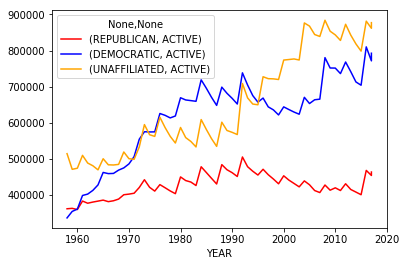

In [26]:
check_totals(combined)[filter(
    lambda x: x[1] == "ACTIVE" and x[0] in ["DEMOCRATIC","REPUBLICAN","UNAFFILIATED"],
    full_index()
)].plot(colors=["RED","BLUE","ORANGE"])

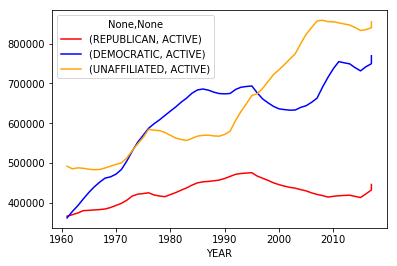

In [27]:
check_totals(combined)[filter(
    lambda x: x[1] == "ACTIVE" and x[0] in ["DEMOCRATIC",
                                            "REPUBLICAN",
                                            "UNAFFILIATED"],
    full_index()
)].rolling(4).mean().plot(colors=["RED","BLUE","ORANGE"])

In [28]:
def add_pct_col(df):
    
    ret = df.copy()
    
    ret = ret[filter(lambda x: x[1] in ["_COMPUTED_TOTAL"],
                     ret.columns.tolist())]
    
    parties = ret.columns.get_level_values(0).unique()
    
    for party in parties:
        ret[party,"_PCT"] = ret[party,"_COMPUTED_TOTAL"] / ret["TOTAL REGISTERED","_COMPUTED_TOTAL"]

        party = None
        
    ret = ret[parties]
    
    return ret

add_pct_col(check_totals(combined))

    

DEMOCRATIC             OTHER PARTIES                REPUBLICAN  \
     _COMPUTED_TOTAL      _PCT _COMPUTED_TOTAL      _PCT _COMPUTED_TOTAL   
YEAR                                                                       
1958        335887.0  0.277317             0.0  0.000000        361257.0   
1959        353907.0  0.298166             0.0  0.000000        362395.0   
1960        360363.0  0.302001             0.0  0.000000        359162.0   
1961        398136.0  0.308611             0.0  0.000000        382621.0   
1962        401932.0  0.317328             0.0  0.000000        376617.0   
1963        412174.0  0.323895             0.0  0.000000        379838.0   
1964        427352.0  0.334122             0.0  0.000000        382492.0   
1965        461979.0  0.342916             0.0  0.000000        385257.0   
1966        458730.0  0.346379          1461.0  0.001103        381003.0   
1967        459256.0  0.346170          1344.0  0.001013        383438.0   
1968        468481.0  0.349217           561.0  0.000418        388165.0   
1969        474565.0  0.340446           522.0  0.000374        400142.0   
1970        485657.0  0.349851           534.0  0.000385        401877.0   
1971        505835.0  0.358978           597.0  0.000424        404314.0   
1972        554111.0  0.367544           603.0  0.000400        420210.0   
1973        574878.0  0.356627           625.0  0.000388        441790.0   
1974        574238.0  0.367590           581.0  0.000372        420821.0   
1975        574517.0  0.371289           646.0  0.000417        410259.0   
1976        625419.0  0.374646           754.0  0.000452        428214.0   
1977        620399.0  0.381181           999.0  0.000614        419589.0   
1978        613225.0  0.386428           947.0  0.000597        410675.0   
1979        618539.0  0.394936           976.0  0.000623        403118.0   
1980        669131.0  0.392139          1022.0  0.000599        449548.0   
1981        662983.0  0.398903           954.0  0.000574        439472.0   
1982        661181.0  0.401823           956.0  0.000581        435374.0   
1983        659268.0  0.407529            34.0  0.000021        425695.0   
1984        718772.0  0.397984           898.0  0.000497        477749.0   
1985        695537.0  0.399820          1022.0  0.000587        461799.0   
1986        670468.0  0.400770           941.0  0.000562        445745.0   
1987        647927.0  0.401683           912.0  0.000565        429936.0   
...              ...       ...             ...       ...             ...   
1989        681482.0  0.393842           949.0  0.000548        469523.0   
1990        667523.0  0.391958           954.0  0.000560        461374.0   
1991        651750.0  0.389922          1905.0  0.001140        450778.0   
1992        738179.0  0.377532          3655.0  0.001869        504853.0   
1993        704329.0  0.379819          3468.0  0.001870        477907.0   
1994        675129.0  0.375929          3749.0  0.002088        465371.0   
1995        656850.0  0.372225          3396.0  0.001924        454798.0   
1996        668247.0  0.357368          3511.0  0.001878        470774.0   
1997        643859.0  0.352662          4120.0  0.002257        455728.0   
1998        635477.0  0.352097          4141.0  0.002294        443736.0   
1999        621469.0  0.350161          3131.0  0.001764        430528.0   
2000        643822.0  0.343510          4164.0  0.002222        452654.0   
2001        636404.0  0.342754          4461.0  0.002403        440786.0   
2002        629422.0  0.341620          4894.0  0.002656        431443.0   
2003        623453.0  0.341908          4161.0  0.002282        422027.0   
2004        670356.0  0.336877          4465.0  0.002244        438554.0   
2005        699502.0  0.335234          4387.0  0.002102        453715.0   
2006        704811.0  0.344400          2881.0  0.001408        433029.0   
2007        707431.0  0.346015          7718.0  0.003775  

In [29]:
def summary_df(df,sum_col="_PCT"):

    
    ret = df.copy()
    
#     ret = ret[filter(lambda x: x[1] in ["_COMPUTED_TOTAL"],
#                      ret.columns.tolist())]
    
    parties = ret.columns.get_level_values(0).unique()
    
#     for party in parties:
#         ret[party,"_PCT"] = ret[party,"_COMPUTED_TOTAL"] / ret["TOTAL REGISTERED","_COMPUTED_TOTAL"]

#         party = None
        
#     ret = ret[parties]
    
    #ret["ALL OTHER"] = ret["OTHER PARTIES"] + ret["UNAFFILIATED"]

    ret = ret[map(lambda x: (x,sum_col), parties)]
    
    ret.columns = parties
    
    ret["ALL OTHER"] = ret["OTHER PARTIES"] + ret["UNAFFILIATED"]
    
    ret = ret[filter(lambda x: x in ["DEMOCRATIC","REPUBLICAN","ALL OTHER"],
                         ret.columns.tolist())]
    
    return ret

#add_pct_col(check_totals(combined))
summary_df(check_totals(combined),sum_col="_PCT_INACTIVE").tail()

,DEMOCRATIC,REPUBLICAN,ALL OTHER
YEAR,,,
2014,0.092840,0.062545,0.181646
2015,0.094010,0.067750,0.197263
2016,0.068639,0.049849,0.140921
2017,0.090845,0.057571,0.170693
2017,0.082080,0.052962,0.100849


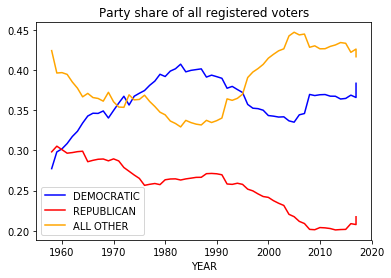

In [30]:
summary_df(add_pct_col(check_totals(combined))).plot(
    colors=["BLUE",
            "RED",
            "ORANGE"],
    title="Party share of all registered voters"
)

In [38]:
print (summary_df(add_pct_col(check_totals(combined))) * 100).to_csv(sep="\t",
                                                                    float_format="%.1f")

YEAR	DEMOCRATIC	REPUBLICAN	ALL OTHER
1958	27.7	29.8	42.4
1959	29.8	30.5	39.7
1960	30.2	30.1	39.7
1961	30.9	29.7	39.5
1962	31.7	29.7	38.5
1963	32.4	29.8	37.8
1964	33.4	29.9	36.7
1965	34.3	28.6	37.1
1966	34.6	28.8	36.6
1967	34.6	28.9	36.5
1968	34.9	28.9	36.1
1969	34.0	28.7	37.2
1970	35.0	28.9	36.1
1971	35.9	28.7	35.4
1972	36.8	27.9	35.4
1973	35.7	27.4	36.9
1974	36.8	26.9	36.3
1975	37.1	26.5	36.4
1976	37.5	25.7	36.9
1977	38.1	25.8	36.1
1978	38.6	25.9	35.5
1979	39.5	25.7	34.8
1980	39.2	26.3	34.4
1981	39.9	26.4	33.7
1982	40.2	26.5	33.4
1983	40.8	26.3	32.9
1984	39.8	26.5	33.7
1985	40.0	26.5	33.5
1986	40.1	26.6	33.3
1987	40.2	26.7	33.2
1988	39.1	27.1	33.7
1989	39.4	27.1	33.5
1990	39.2	27.1	33.7
1991	39.0	27.0	34.0
1992	37.8	25.8	36.4
1993	38.0	25.8	36.2
1994	37.6	25.9	36.5
1995	37.2	25.8	37.0
1996	35.7	25.2	39.1
1997	35.3	25.0	39.8
1998	35.2	24.6	40.2
1999	35.0	24.3	40.7
2000	34.4	24.2	41.5
2001	34.3	23.7	42.0
2002	34.2	23.4	42.4
2003	34.2	23.1	42.7
2004	33.7	22.0	44.3
2005	33.5	21.7	44.7
200

In [31]:
#!open .

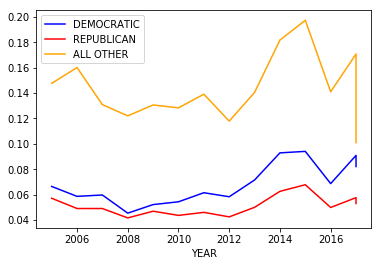

In [32]:
summary_df(check_totals(combined),sum_col="_PCT_INACTIVE").plot(
    colors=["BLUE",
            "RED",
            "ORANGE"]
)

In [33]:
check_totals(combined)

DEMOCRATIC                    OTHER PARTIES                   REPUBLICAN  \
         ACTIVE INACTIVE     TOTAL        ACTIVE INACTIVE    TOTAL     ACTIVE   
YEAR                                                                            
1958   335887.0      NaN       NaN           NaN      NaN      NaN   361257.0   
1959   353907.0      NaN       NaN           NaN      NaN      NaN   362395.0   
1960   360363.0      NaN       NaN           NaN      NaN      NaN   359162.0   
1961   398136.0      NaN       NaN           NaN      NaN      NaN   382621.0   
1962   401932.0      NaN       NaN           NaN      NaN      NaN   376617.0   
1963   412174.0      NaN       NaN           NaN      NaN      NaN   379838.0   
1964   427352.0      NaN       NaN           NaN      NaN      NaN   382492.0   
1965   461979.0      NaN       NaN           NaN      NaN      NaN   385257.0   
1966   458730.0      NaN       NaN        1461.0      NaN      NaN   381003.0   
1967   459256.0      NaN       NaN        1344.0      NaN      NaN   383438.0   
1968   468481.0      NaN       NaN         561.0      NaN      NaN   388165.0   
1969   474565.0      NaN       NaN         522.0      NaN      NaN   400142.0   
1970   485657.0      NaN       NaN         534.0      NaN      NaN   401877.0   
1971   505835.0      NaN       NaN         597.0      NaN      NaN   404314.0   
1972   554111.0      NaN       NaN         603.0      NaN      NaN   420210.0   
1973   574878.0      NaN       NaN         625.0      NaN      NaN   441790.0   
1974   574238.0      NaN       NaN         581.0      NaN      NaN   420821.0   
1975   574517.0      NaN       NaN         646.0      NaN      NaN   410259.0   
1976   625419.0      NaN       NaN         754.0      NaN      NaN   428214.0   
1977   620399.0      NaN       NaN         999.0      NaN      NaN   419589.0   
1978   613225.0      NaN       NaN         947.0      NaN      NaN   410675.0   
1979   618539.0      NaN       NaN         976.0      NaN      NaN   403118.0   
1980   669131.0      NaN       NaN        1022.0      NaN      NaN   449548.0   
1981   662983.0      NaN       NaN         954.0      NaN      NaN   439472.0   
1982   661181.0      NaN       NaN         956.0      NaN      NaN   435374.0   
1983   659268.0      NaN       NaN          34.0      NaN      NaN   425695.0   
1984   718772.0      NaN       NaN         898.0      NaN      NaN   477749.0   
1985   695537.0      NaN       NaN        1022.0      NaN      NaN   461799.0   
1986   670468.0      NaN       NaN         941.0      NaN      NaN   445745.0   
1987   647927.0      NaN       NaN         912.0      NaN      NaN   429936.0   
...         ...      ...       ...           ...      ...      ...        ...   
1989   681482.0      NaN       NaN         949.0      NaN      NaN   469523.0   
1990   667523.0      NaN       NaN         954.0      NaN      NaN   461374.0   
1991   651750.0      NaN       NaN        1905.0      NaN      NaN   450778.0   
1992   738179.0      NaN       NaN        3655.0      NaN      NaN   504853.0   
1993   704329.0      NaN       NaN        3468.0      NaN      NaN   477907.0   
1994   675129.0      NaN       NaN        3749.0      NaN      NaN   465371.0   
1995   656850.0      NaN       NaN        3396.0      NaN      NaN   454798.0   
1996   668247.0      NaN       NaN        3511.0      NaN      NaN   470774.0   
1997   643859.0      NaN       NaN        4120.0      NaN      NaN   455728.0   
1998   635477.0      NaN       NaN        4141.0      NaN      NaN   443736.0   
1999   621469.0      NaN       NaN        3131.0      NaN      NaN   430528.0   
2000   643822.0      NaN       NaN        4164.0      NaN      NaN   452654.0   
2001   636404.0      NaN       NaN        4461.0      NaN      NaN   440786.0   
2002   629422.0      NaN       NaN        4894.0      NaN      NaN   431443.0   
2003   623453.0      NaN       NaN        4161.0      NaN      NaN   422027.0   
2004   670356.0      NaN       NaN  